In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import PIL
from PIL import Image
from tqdm import tqdm
from torchsummary import summary
import os
import random
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Inception_naive(nn.Module):
    def __init__(self, in_channels, conv1x1, conv3x3, conv5x5, pool_proj):
        super(Inception, self).__init__()
        self.conv1x1 = ConvBlock(in_channels, conv1x1, kernel_size=1)
        self.conv3x3 = ConvBlock(in_channels, conv3x3, kernel_size=3, padding=1)
        self.conv5x5 = ConvBlock(in_channels, conv5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool = ConvBlock(in_channels, pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1x1(x)

        x2 = self.conv3x3(x)

        x3 = self.conv5x5(x)

        x4 = self.maxpool(x)
        x4 = self.pool(x4)

        x = torch.concat([x1, x2, x3, x4], 1)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, conv1x1, conv3x3, conv3x3_reduce, conv5x5, conv5x5_reduce, pool_proj):
        super(Inception, self).__init__()
        self.conv1x1 = ConvBlock(in_channels, conv1x1, kernel_size=1)

        self.conv3x3_reduce = ConvBlock(in_channels, conv3x3_reduce, kernel_size=1)
        self.conv3x3 = ConvBlock(conv3x3_reduce, conv3x3, kernel_size=3, padding=1)

        self.conv5x5_reduce = ConvBlock(in_channels, conv5x5_reduce, kernel_size=1)
        self.conv5x5 = ConvBlock(conv5x5_reduce, conv5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool = ConvBlock(in_channels, pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1x1(x)

        x2 = self.conv3x3_reduce(x)
        x2 = self.conv3x3(x2)

        x3 = self.conv5x5_reduce(x)
        x3 = self.conv5x5(x3)

        x4 = self.maxpool(x)
        x4 = self.pool(x4)

        x = torch.concat([x1, x2, x3, x4], 1)
        return x
    
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            nn.Conv2d(in_channels, 128, kernel_size=1)
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv_layer(x)
    
model = Inception(192, 64, 128, 96, 32, 16, 32).to(device)
print(summary(model, (192, 56, 56)))
model2 = InceptionAux(512, 10).to(device)
print(summary(model2, (512, 14, 14)))
dummy = torch.randn(1, 192, 56, 56).to(device)
print(model(dummy).shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          12,352
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         ConvBlock-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 96, 56, 56]          18,528
       BatchNorm2d-6           [-1, 96, 56, 56]             192
              ReLU-7           [-1, 96, 56, 56]               0
         ConvBlock-8           [-1, 96, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]         110,720
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        ConvBlock-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]           3,088
      BatchNorm2d-14           [-1, 16,

In [22]:
class GoogLeNet(nn.Module):
    def __init__(self, auxtility=True, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.auxtility = auxtility

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 128, 96, 32, 16, 32)
        self.inception3b = Inception(256, 128, 192, 128, 96, 32, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        if self.auxtility:
            self.aux1 = InceptionAux(512, 10)
        self.inception4a = Inception(480, 192, 208, 96, 48, 16, 64)
        self.inception4b = Inception(512, 160, 224, 112, 64, 24, 64)
        self.inception4c = Inception(512, 128, 256, 128, 64, 24, 64)
        self.inception4d = Inception(512, 112, 288, 144, 64, 32, 64)
        self.inception4e = Inception(528, 256, 320, 160, 128, 32, 128)
        self.maxpool4= nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        if self.auxtility:
            self.aux2 = InceptionAux(528, 10)
        self.inception5a = Inception(832, 256,320, 160, 128, 32, 128)
        self.inception5b = Inception(832, 384, 384, 192, 128, 48, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        if self.auxtility:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.auxtility:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.auxtility and self.training:
            return x, aux1, aux2
        return x
    
model3 = GoogLeNet().to(device)
print(summary(model3, (3,224,224)))

dummy = torch.randn(1, 3, 224, 224).to(device)
output = model3(dummy)
if model3.auxtility and model3.training:
    print([o.shape for o in output])
else:
    print(output.shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 192, 54, 54]         110,784
         MaxPool2d-4          [-1, 192, 27, 27]               0
            Conv2d-5           [-1, 64, 27, 27]          12,352
       BatchNorm2d-6           [-1, 64, 27, 27]             128
              ReLU-7           [-1, 64, 27, 27]               0
         ConvBlock-8           [-1, 64, 27, 27]               0
            Conv2d-9           [-1, 96, 27, 27]          18,528
      BatchNorm2d-10           [-1, 96, 27, 27]             192
             ReLU-11           [-1, 96, 27, 27]               0
        ConvBlock-12           [-1, 96, 27, 27]               0
           Conv2d-13          [-1, 128, 27, 27]         110,720
      BatchNorm2d-14          [-1, 128,

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_data(root_dir):
    classes = os.listdir(root_dir)
    cls_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    images = []
    labels = []

    for cls_name in classes:
        cls_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            images.append(img_path)
            labels.append(cls_to_idx[cls_name])

    return images, labels

# Define transformations for the original images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# 전처리 함수 정의
def random_resized_crop(img):
    aspect_ratio = random.uniform(3/4, 4/3)
    scale = random.uniform(0.08, 1.0)
    width, height = img.size
    target_area = scale * width * height
    target_width = int(round((target_area * aspect_ratio) ** 0.5))
    target_height = int(round((target_area / aspect_ratio) ** 0.5))
    
    if target_width > width or target_height > height:
        target_width = width
        target_height = height
        
    img = transforms.functional.resized_crop(img, random.randint(0, height - target_height), random.randint(0, width - target_width), target_height, target_width, (224, 224))
    return img

def photometric_distort(img):
    if random.random() > 0.5:
        img = transforms.functional.adjust_brightness(img, random.uniform(0.5, 1.5))
    if random.random() > 0.5:
        img = transforms.functional.adjust_contrast(img, random.uniform(0.5, 1.5))
    if random.random() > 0.5:
        img = transforms.functional.adjust_saturation(img, random.uniform(0.5, 1.5))
    if random.random() > 0.5:
        img = transforms.functional.adjust_hue(img, random.uniform(-0.1, 0.1))
    return img

def random_interpolation(img):
    methods = [transforms.InterpolationMode.BILINEAR, transforms.InterpolationMode.NEAREST, transforms.InterpolationMode.BICUBIC, transforms.InterpolationMode.BOX]
    method = random.choice(methods)
    img = transforms.functional.resize(img, (224, 224), interpolation=method)
    return img

transform_train = transforms.Compose([
    transforms.Lambda(random_resized_crop),
    transforms.Lambda(photometric_distort),
    transforms.Lambda(random_interpolation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path, output_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    np.save(output_path, image.numpy())

def preprocess_directory(input_dir, output_dir, transform):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.JPEG')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_dir)
                output_path = os.path.join(output_dir, relative_path, os.path.splitext(file)[0] + '.npy')

                if not os.path.exists(os.path.join(output_dir, relative_path)):
                    os.makedirs(os.path.join(output_dir, relative_path))
                
                preprocess_image(input_path, output_path, transform)
                print(f'Processed {input_path} -> {output_path}')

train_input_dir = 'E:\\puzzle\\data\\ImageNet10\\train'
train_output_dir = 'E:\\puzzle\\data\\ImageNet10\\preprocessed\\train'

val_input_dir = 'E:\\puzzle\\data\\ImageNet10\\val'
val_output_dir = 'E:\\puzzle\\data\\ImageNet10\\preprocessed\\val'

preprocess_directory(train_input_dir, train_output_dir, transform_train)
preprocess_directory(val_input_dir, val_output_dir, transform_val)

Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10001.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10001.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10006.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10006.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10012.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10012.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10044.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10044.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10051.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10051.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10064.JPEG -> E:\puzzle\data\ImageNet10\preprocessed\train\airplane\n02690373_10064.npy
Processed E:\puzzle\data\ImageNet10\train\airplane\n02690373_10079.JPEG -> E:\puzzle\data\ImageNet10\prepr

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import copy

class NPYDataset(Dataset):
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(npy_dir))

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(npy_dir, class_dir)
            for file in os.listdir(class_path):
                if file.endswith('.npy'):
                    self.data.append(os.path.join(class_path, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        npy_path = self.data[idx]
        image = np.load(npy_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def to_tensor(image):
    return torch.tensor(image, dtype=torch.float)

train_dataset = NPYDataset('E:\\puzzle\\data\\ImageNet10\\preprocessed\\train', transform=to_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = NPYDataset('E:\\puzzle\\data\\ImageNet10\\preprocessed\\val', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
model = GoogLeNet().to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, outputs, target, opt=None):
    if isinstance(outputs, tuple):
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output, target)
    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in tqdm(dataset_dl):
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        lr_scheduler.step()

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' % (train_loss, val_loss, 100 * val_metric, (time.time() - start_time) / 60))
        print('-' * 10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

params_train = {
    "num_epochs": 90,
    "loss_func": loss_func,
    "optimizer": optimizer,
    "train_dl": train_loader,
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "best_weights.pt",
}

# 학습 및 유효성 검사 수행
model, loss_history, metric_history = train_val(model, params_train)


NameError: name 'transform_val' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

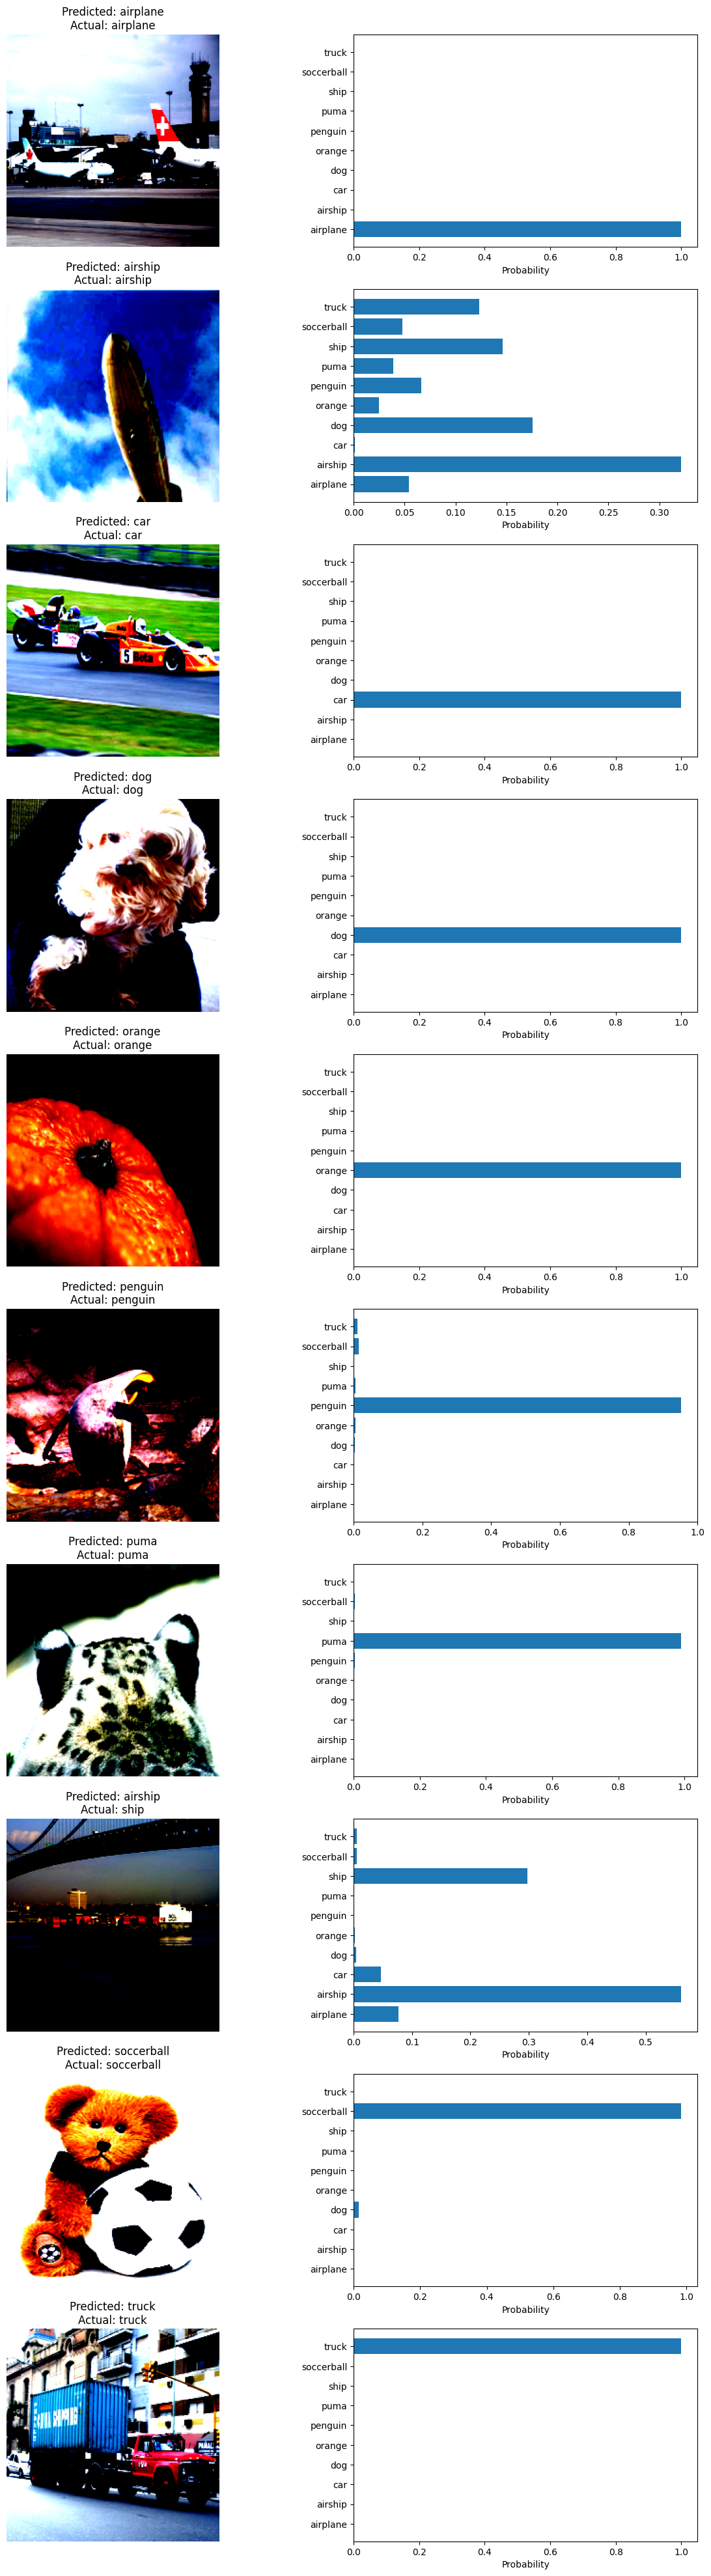

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image


# 클래스 이름 정의
class_names = train_dataset.classes

# 예측 결과 시각화 함수 정의
def visualize_predictions(model, loader, device, class_names, num_images=5):
    model.eval()
    images_seen = {class_name: False for class_name in class_names}
    images_so_far = 0

    plt.figure(figsize=(15, len(class_names) * 5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                actual_class = class_names[labels[j]]
                if not images_seen[actual_class]:
                    images_seen[actual_class] = True
                    index = list(images_seen.keys()).index(actual_class) + 1

                    plt.subplot(len(class_names), 2, 2 * index - 1)
                    plt.imshow(images.cpu().data[j].permute(1, 2, 0).numpy())
                    plt.title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                    plt.axis('off')

                    plt.subplot(len(class_names), 2, 2 * index)
                    probabilities = torch.nn.functional.softmax(outputs[j], dim=0)
                    plt.barh(range(len(class_names)), probabilities.cpu().numpy())
                    plt.yticks(range(len(class_names)), class_names)
                    plt.xlabel('Probability')

            if all(images_seen.values()):
                break

    plt.show()

# 검증 데이터셋에서 예측 결과 시각화
visualize_predictions(model, val_loader, device, class_names, num_images=5)